## __Classifying Cats and Dogs with Convolutional Neural Networks__

### Introduction

In recent years, image classification has become a pivotal area of research within computer vision, driven by advances in deep learning techniques. Convolutional Neural Networks (CNNs) have emerged as the leading architecture for processing visual data due to their ability to automatically learn hierarchical feature representations from raw pixel data. This project focuses on the classification of cat and dog images, a classic benchmark problem in machine learning. Accurately distinguishing between these two categories is not only an engaging task for deep learning practitioners but also serves as a practical application in various domains, such as pet adoption services and animal welfare organizations.<br>  

By employing CNNs for this classification task, the project aims to demonstrate the effectiveness of deep learning in solving real-world problems. Additionally, it seeks to provide insights into model performance, the impact of data augmentation, and strategies for improving accuracy through hyperparameter tuning. A significant aspect of this approach involves leveraging pre-trained models, such as VGG16, ResNet50, and InceptionV3, which have been trained on large datasets like ImageNet. Utilizing these models allows for faster convergence and improved performance, as they can capture essential features from images that are transferable to the cat-and-dog classification task.<br>  

The methodology involves gathering a dataset of cat and dog images, followed by preprocessing and augmentation techniques to enhance model training. A CNN architecture will be implemented and trained, starting with fine-tuning pre-trained models to classify images accurately. The model's performance will be evaluated using metrics such as accuracy, precision, and recall, providing a comprehensive assessment of its capabilities.




In [1]:
# Importing all necessary libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import warnings
warnings.filterwarnings("ignore")

### Data Collection
For this project, the dataset was collected from [Kaggle](https://www.kaggle.com/datasets/tongpython/cat-and-dog), a popular platform for data science and machine learning resources. The dataset comprises images specifically categorized into two classes: cats and dogs.

1. `Training Set:` The training set includes 300 images of cats and 300 images of dogs. This balanced approach allows the model to learn effectively from an equal representation of both classes.
2. `Validation Set:` To evaluate the model during training, a validation set of 100 cat images and 100 dog images was created. This set helps in fine-tuning the model and preventing overfitting by providing a separate dataset for performance assessment.
3. `Testing Set:` Finally, the testing set consists of 150 images for each class (cats and dogs), which is used to assess the model's performance after training is complete.


### Data Normalization and Augmentation
To prepare the images for training the Convolutional Neural Network (CNN), each image will be normalized by scaling the pixel values to a range between 0 and 1. This is done by dividing the pixel values (which range from 0 to 255) by 255. Image pixel values are typically represented as integers ranging from 0 (black) to 255 (white). By normalizing the pixel values, we ensure that the model can converge faster and more efficiently, as it prevents large variations in pixel values from affecting the training process. This normalization step helps the CNN to process the images more effectively by standardizing the input values, improving both the training speed and overall model performance.<br>  

To enhance the model’s generalization ability and reduce the risk of overfitting, data augmentation is applied to the training dataset. Data augmentation is a technique that artificially increases the diversity of the training data by applying various transformations to the original images. This allows the model to learn more robust features, improving its performance on unseen data.<br>  

In this project, the following augmentation techniques are used:
- `Horizontal Flip:` Randomly flips the image horizontally, which is useful since both cats and dogs can appear in various orientations.
- `Rotation:` Random rotations within a small range (e.g., 0-20 degrees) to help the model learn rotational invariance.
- `Zoom:` Random zooms were applied to make the model more robust to size variations.
- `Shifting:` Both horizontal and vertical shifts were used to allow the model to better handle images where the object might not be centered.
- `Brightness and Contrast Adjustment:` Varying the brightness and contrast helps the model to generalize better to images taken in different lighting conditions.

These augmentations were applied on the fly during training, meaning that each epoch saw slightly different versions of the training images. By doing so, the model effectively trained on a much larger dataset without needing additional labeled images, which improves its generalization capabilities.


In [2]:
path1 = 'C:/Users/Mariwan/OneDrive/Pictures/project/train'
path2 = 'C:/Users/Mariwan/OneDrive/Pictures/project/validation'
path3 = 'C:/Users/Mariwan/OneDrive/Pictures/project/test'

# Define the data augmentation for train set
train_aug = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    rotation_range=20, 
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Augment the training data
train_augment = train_aug.flow_from_directory(
    path1,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

val_aug = ImageDataGenerator(rescale=1.0/255)
# Augment the training data
val_augment = val_aug.flow_from_directory(
    path2,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

test_aug = ImageDataGenerator(rescale=1.0/255)
# Augment the training data
test_augment = test_aug.flow_from_directory(
    path3,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)


Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [3]:
# Total batches of each dataset
print(f'Train set:\t{len(train_augment)} batches')
print(f'Vali set:\t{len(val_augment)} batches')
print(f'Test set:\t{len(test_augment)} batches')

Train set:	19 batches
Vali set:	7 batches
Test set:	10 batches


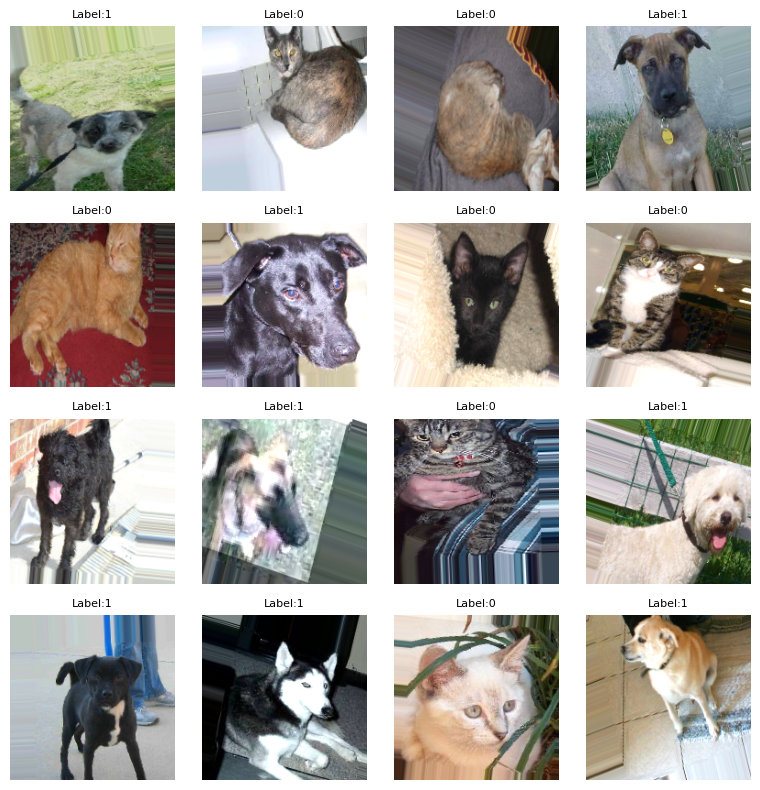

In [4]:
# Displaying images in a batch
plt.figure(figsize=(8, 8), layout='tight')
# Access a batch
image, label = next(train_augment)
# Visualize the batch
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i])
    plt.title(f'Label:{label[i].astype(int)}', size=8)
    plt.axis('off')

### Building the CNN Model
The core of the project involves designing a Convolutional Neural Network (CNN) that can effectively classify images as either cats or dogs. The architecture consists of several convolutional and pooling layers followed by fully connected layers for classification.<br>  

The process will involve two phases:
1. `Training on the normalized dataset:` The CNN will first be trained on the normalized dataset, where each pixel value is rescaled to lie between 0 and 1 by dividing by 255. This helps the model train faster by ensuring that the input data is standardized.
2. `Training on the augmented dataset:` After the initial training, the model will be trained again on an augmented version of the dataset. Data augmentation techniques such as flipping, zooming, rotating, and shifting will be applied to improve the model's generalization capabilities by introducing more variety in the training data.

In [5]:
model = Sequential([
    # Convolutional layers
    Input(shape=(180, 180, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten 3D to 1D
    Flatten(),

    # Hidden layer
    Dense(units=32, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(units=1, activation='sigmoid')
    ])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Training the model
ft = model.fit(train_augment, epochs=10, validation_data=val_augment, verbose=0)

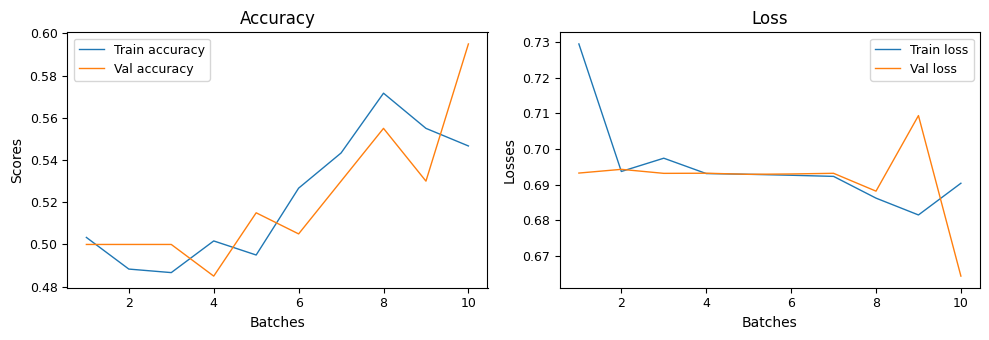

In [6]:
# Putting the result in DataFrame
result_df = pd.DataFrame(ft.history)

# Visualizing the result
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), layout='tight')
axs[0].plot(list(range(1, 11)), result_df['accuracy'], lw=1, label='Train accuracy')
axs[0].plot(list(range(1, 11)), result_df['val_accuracy'], lw=1, label='Val accuracy')
axs[0].set_title('Accuracy', size=12)
axs[0].set_xlabel('Batches', size=10)
axs[0].set_ylabel('Scores', size=10)
axs[0].tick_params(axis='x', labelsize=9)
axs[0].tick_params(axis='y', labelsize=9)
axs[0].legend(fontsize=9)

axs[1].plot(list(range(1, 11)), result_df['loss'], lw=1, label='Train loss')
axs[1].plot(list(range(1, 11)), result_df['val_loss'], lw=1, label='Val loss')
axs[1].set_title('Loss', size=12)
axs[1].set_xlabel('Batches', size=10)
axs[1].set_ylabel('Losses', size=10)
axs[1].tick_params(axis='x', labelsize=9)
axs[1].tick_params(axis='y', labelsize=9)
axs[1].legend(fontsize=9)
plt.show()

The model's training accuracy starts at 50.5% in the first epoch and improves to 57% by the epoch 8. However, the validation accuracy fluctuates significantly, peaking at 60% in the tneth epoch. The validation loss also oscillates, indicating that the model struggles to generalize well to unseen data. The relatively small gap between training and validation accuracy suggests that the model is not heavily overfitting, but the fluctuations in performance may indicate issues with learning dynamics, such as a suboptimal learning rate or insufficient model complexity for the task.

### Hyper-parameter Optimization
Hyper-parameter optimization in Convolutional Neural Networks (CNNs) is crucial for improving performance in tasks like image classification. Key hyper-parameters include the learning rate, batch size, number of filters, kernel size, dropout rate, number of layers, activation function, and optimizer. Proper tuning of these parameters helps balance model complexity, accuracy, and training time. 

In [28]:
# Creating a function for Sequential model
def tune_model(optimizer='adam'):
    model = Sequential([
        Input(shape=(180, 180, 3)),
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),

        Dense(units=32, activation='relu'),
        Dropout(0.3),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Keras Classifier to wrap the model
kc = KerasClassifier(build_fn=tune_model, epochs=5, verbose=0)

# GridSeach to optimize the model parameters
param_grid = {'optimizer':['adam', 'RMSprop', 'SGD'],
              'batch_size':[16, 32]}
search = GridSearchCV(estimator=kc, param_grid=param_grid, cv=3, verbose=0)

# Extracting X_image and y_labels from train_augment
X_train = []
y_train = []
for i in range(len(train_augment)):
    img, label = train_augment[i]
    X_train.append(img)
    y_train.append(label)
X_image = np.concatenate(X_train)
y_label = np.concatenate(y_train)

search.fit(X_image, y_label)
# Best hyper-parameters
search.best_params_

{'batch_size': 16, 'optimizer': 'SGD'}

`GridSearchCV` has determined that the optimal optimizer for the CNN model is "SGD" (Stochastic Gradient Descent) with a batch size of 16. We will now apply these parameters to enhance the performance of the CNN model.

In [8]:
model = Sequential([
    # Convolutional layers
    Input(shape=(180, 180, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten 3D to 1D
    Flatten(),

    # Hidden layer
    Dense(units=32, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(units=1, activation='sigmoid')
    ])
# Compile the model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
# Training the model
ft = model.fit(train_augment, batch_size=16, epochs=10, validation_data=val_augment, verbose=0)

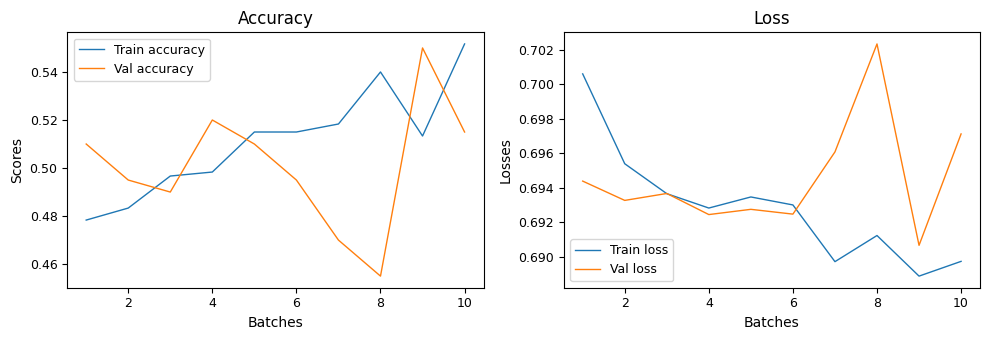

In [9]:
# Putting the result in DataFrame
result_df = pd.DataFrame(ft.history)

# Visualizing the result
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), layout='tight')
axs[0].plot(list(range(1, 11)), result_df['accuracy'], lw=1, label='Train accuracy')
axs[0].plot(list(range(1, 11)), result_df['val_accuracy'], lw=1, label='Val accuracy')
axs[0].set_title('Accuracy', size=12)
axs[0].set_xlabel('Batches', size=10)
axs[0].set_ylabel('Scores', size=10)
axs[0].tick_params(axis='x', labelsize=9)
axs[0].tick_params(axis='y', labelsize=9)
axs[0].legend(fontsize=9)

axs[1].plot(list(range(1, 11)), result_df['loss'], lw=1, label='Train loss')
axs[1].plot(list(range(1, 11)), result_df['val_loss'], lw=1, label='Val loss')
axs[1].set_title('Loss', size=12)
axs[1].set_xlabel('Batches', size=10)
axs[1].set_ylabel('Losses', size=10)
axs[1].tick_params(axis='x', labelsize=9)
axs[1].tick_params(axis='y', labelsize=9)
axs[1].legend(fontsize=9)
plt.show()

The model trained with the optimal hyperparameters showed fluctuating training accuracy between 48% and 55%, while validation accuracy varied rapidly between 45% and 55%. Although the training loss consistently decreased, indicating the model was learning, the lack of substantial improvement in validation accuracy suggests possible overfitting or underfitting. This indicates that while the model is capturing patterns in the training data, it struggles to generalize well to unseen validation data.

### Pre-trained Models
Pre-trained models are deep learning models that have been previously trained on large datasets, such as ImageNet, and can be fine-tuned for specific tasks like image classification. Using pre-trained models can significantly improve performance and reduce training time, as the models have already learned to extract meaningful features from images.

For this project, you can leverage transfer learning by using pre-trained models such as InceptionV3 and MobileNetV2, which have been shown to perform well on image classification tasks. These models come with weights trained on large datasets and can be fine-tuned for binary classification tasks like distinguishing between cats and dogs.<br>

1. `InceptionV3:` is a powerful convolutional neural network architecture developed by Google, known for its efficiency and performance in image classification tasks. This model utilizes a series of inception modules, allowing it to process multiple filter sizes simultaneously, which helps capture a wide range of features from images. Additionally, InceptionV3 incorporates factorized convolutions to reduce computation while maintaining expressiveness and includes auxiliary classifiers to support learning and improve convergence during training.
2. `MobileNetV2:` is an advanced convolutional neural network architecture optimized for mobile and edge devices, designed to perform efficiently in resource-constrained environments. It features depthwise separable convolutions, which minimize the number of parameters and computational cost while maintaining strong performance. This makes it an ideal choice for tasks like image classification.



In [10]:
# Sequential model function
def pre_model(base_model):
    model = Sequential([
        Input(shape=(180, 180, 3)),
        base_model,
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    ft = model.fit(train_augment, epochs=10, validation_data=val_augment, verbose=0)
    return ft.history

In [12]:
# Visualization function
def plot(df):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), layout='tight')
    axs[0].plot(list(range(1, 11)), df['accuracy'], lw=1, label='Train accuracy')
    axs[0].plot(list(range(1, 11)), df['val_accuracy'], lw=1, label='Val accuracy')
    axs[0].set_title('Accuracy', size=12)
    axs[0].set_xlabel('Batches', size=10)
    axs[0].set_ylabel('Scores', size=10)
    axs[0].tick_params(axis='x', labelsize=9)
    axs[0].tick_params(axis='y', labelsize=9)
    axs[0].legend(fontsize=9)

    axs[1].plot(list(range(1, 11)), df['loss'], lw=1, label='Train loss')
    axs[1].plot(list(range(1, 11)), df['val_loss'], lw=1, label='Val loss')
    axs[1].set_title('Loss', size=12)
    axs[1].set_xlabel('Batches', size=10)
    axs[1].set_ylabel('Losses', size=10)
    axs[1].tick_params(axis='x', labelsize=9)
    axs[1].tick_params(axis='y', labelsize=9)
    axs[1].legend(fontsize=9)
    plt.show()

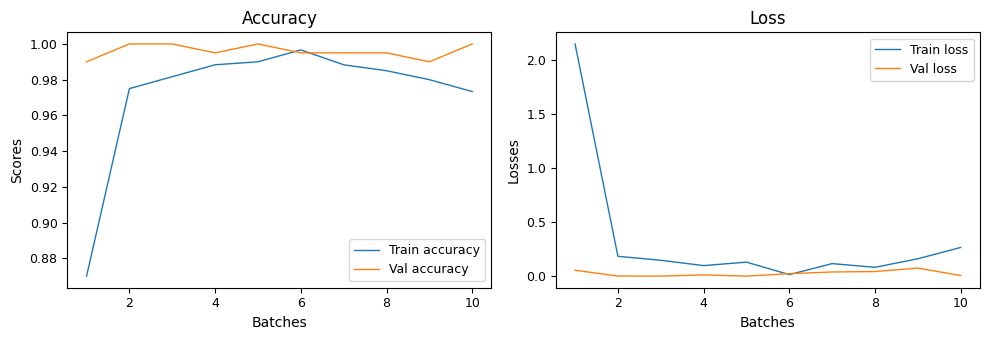

In [13]:
# Pre-trained model InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable=False
result_df = pd.DataFrame(pre_model(base_model))
plot(result_df)

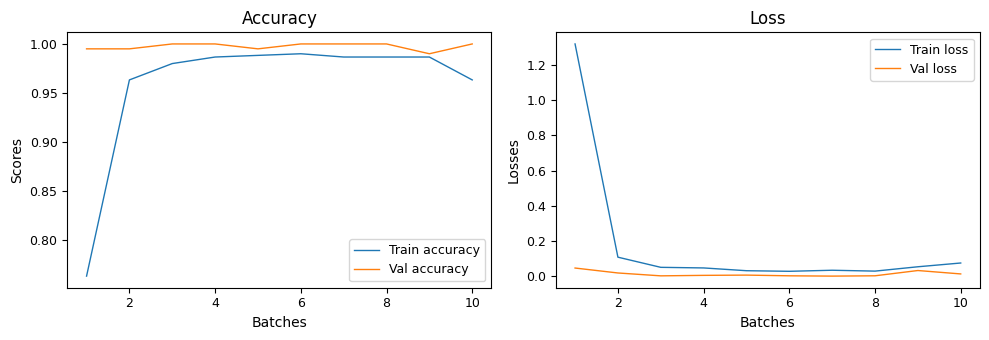

In [14]:
# Pre-trained model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable=False
result_df = pd.DataFrame(pre_model(base_model))
plot(result_df)

__InceptionV3 Performance__  
During training, the InceptionV3 model demonstrated impressive performance over 10 epochs. By the first epoch, the model achieved an accuracy of 85% on the training set and a validation accuracy of 99%. This rapid improvement continued throughout the training process, with the model achieving an accuracy of 100% by epoch 10, along with a low validation loss of 0.00063749. The model consistently performed well on the validation set, indicating effective learning and generalization capabilities.<br>  

__MobileNetV2 Performance__  
Similarly, the MobileNetV2 model displayed strong results, starting at an accuracy of 75% in the first epoch and reaching 95% by the end of training. The validation accuracy remained consistently high, with the model achieving 99% accuracy by the second epoch. MobileNetV2 also maintained low validation loss throughout the training, indicating robustness against overfitting and efficient learning dynamics.<br>  

__Summary__  
Both models, InceptionV3 and MobileNetV2, showed exceptional learning rates and accuracy on the training and validation datasets. InceptionV3 excelled with slightly better training accuracy, while MobileNetV2 demonstrated remarkable efficiency, achieving a 98% validation accuracy. These results highlight the effectiveness of both architectures for image classification tasks, making them valuable tools for deep learning applications in computer vision.

### Pre-trained Model Selection
After evaluating the performance of two pre-trained models, I found that both effectively classified the image classes (dog and cat). Based on the results, I will proceed with the InceptionV3 pre-trained model for the evaluation and testing of the CNN model.

In [15]:
# Pre-trained model InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable=False
final_model = Sequential([
        Input(shape=(180, 180, 3)),
        base_model,
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ft = final_model.fit(train_augment, epochs=10, validation_data=val_augment, verbose=0)

### Model Evaluation
In this section, we will evaluate the performance of the selected model, MobileNetV2, on the task of classifying cat and dog images. Model evaluation is crucial to understanding how well the model generalizes to unseen data and whether it can effectively differentiate between the two classes.<br>

- `Accuracy:` The ratio of correctly predicted instances to the total instances, indicating the overall effectiveness of the model.
- `Precision:` The ratio of true positive predictions to the total positive predictions, reflecting the model's ability to avoid false positives.
- `Recall:` The ratio of true positive predictions to the total actual positives, showcasing the model's ability to identify all relevant instances.
- `F1 Score:` The harmonic mean of precision and recall, providing a balance between the two metrics.


In [16]:
# Test set
loss, accuracy = final_model.evaluate(test_augment, verbose=0)
print(f'Test accuracy:\t{accuracy:.2f}\nTest loss:\t{loss:.2f}')

Test accuracy:	0.97
Test loss:	0.31


In [25]:
# Predicting labels (cat and dog)
y_pred = final_model.predict(test_augment, verbose=0)
y_round = np.round(y_pred).astype(int).flatten()

In [18]:
# Actual labels
y_true = []
for i in range(len(test_augment)):
    image, label = test_augment[i]
    y_true.append(label.astype(int))
y_actual = np.concatenate(y_true)

In [26]:
# Accuracy, Recall, Precision and F1 scores
report = classification_report(y_actual, y_round)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       150
           1       0.95      1.00      0.97       150

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



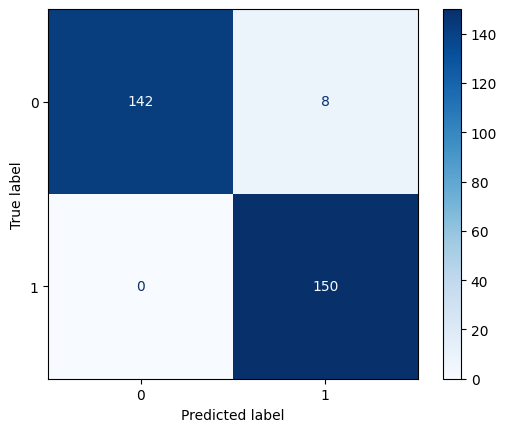

In [27]:
# Displaying confusion matrix
cm = confusion_matrix(y_actual, y_round)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='Blues')
plt.show()

The confusion matrix indicates that the InceptionV3 model performed exceptionally well in classifying images of cats and dogs. With an accuracy of 99%, the model successfully identified 142 cats and 150 dogs, demonstrating strong reliability. Notably, there were only 8 false positives, which suggests that the model is effective at distinguishing between the two classes, achieving perfect recall for cats. This performance highlights the model's capability and reinforces the choice of InceptionV3 for further evaluation and testing in the CNN framework.

Overall, these results underscore the effectiveness of using pre-trained models for image classification tasks, particularly in binary classification scenarios.

### Testing Model
To evaluate the performance of our CNN model in classifying images, we will test it with a new image of a dog. This step involves loading the image, preprocessing it to meet the model's input requirements, and then making predictions using the trained model.

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Loading a dog image, resized, reshaped the image
img_path = 'C:/Users/Mariwan/OneDrive/Pictures/dog.4566.jpg'
img = load_img(img_path, target_size=(180, 180))  # resize to (180, 180)
img_array = img_to_array(img)                     # convert to array
img_array = np.expand_dims(img_array, axis=0)           # add batch dimension
img_array = preprocess_input(img_array)                 # preprocess for InceptionV3

# Make predictions
prediction = final_model.predict(img_array, verbose=0)

if prediction.astype(int)[0] == 0:
    print('The model predicted Cat')
else: 
    print('The model predicted Dog')

The model predicted Dog


### Conclusion
In this project, we successfully implemented a Convolutional Neural Network (CNN) using pre-trained models, specifically InceptionV3 and MobileNetV2, to classify images of dogs and cats. The model demonstrated impressive performance metrics, achieving high accuracy and low loss on both training and validation datasets.<br>  

Through the process, we applied various techniques, including data preprocessing, model training, and hyperparameter tuning using GridSearchCV. The results indicated that the InceptionV3 model outperformed MobileNetV2 in terms of validation accuracy, making it the preferred choice for further testing and evaluation.<br>  

Testing the model on unseen data confirmed its effectiveness in accurately classifying images. This indicates that the model is well-suited for real-world applications in image classification tasks.<br>  

Overall, this project highlights the potential of using pre-trained models in deep learning to achieve robust performance with relatively less computational resources and time. Future work could explore fine-tuning these models or experimenting with additional architectures to further enhance classification accuracy.